# 02 - Santiago OSMnx Network

This notebook creates a Network (G,nodes,edges) for a bbox around Santiago (Chile) using __city 'AM_Santiago'__ and saves it to db.

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

In [10]:
##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

# save output to database?
save = False
if_exists='replace'

##### WARNING ##### WARNING ##### WARNING ##### WARNING ##### WARNING #####

In [3]:
city = 'AM_Santiago'

## Load aoi

In [4]:
# aoi_gdf
aoi_schema = 'projects_research'
aoi_table = 'santiago_aoi'

query = f"SELECT * FROM {aoi_schema}.{aoi_table} WHERE \"city\" LIKE \'{city}\'"
aoi_gdf = aup.gdf_from_query(query, geometry_col='geometry')
aoi_gdf = aoi_gdf.set_crs("EPSG:4326")

city_list = list(aoi_gdf.city.unique())

# Show
print(aoi_gdf.shape)
print(len(city_list))
print(city_list)
aoi_gdf.head(1)

(1, 2)
1
['AM_Santiago']


,city,geometry
0,AM_Santiago,"MULTIPOLYGON (((-70.69165 -33.80508, -70.69167..."


<Axes: >

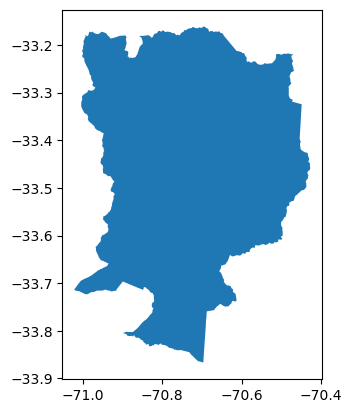

In [5]:
aoi_gdf.plot()

## Run function create_osmnx_network and save OSMnx Network

In [6]:
save_schema = 'projects_research'
nodes_save_table = 'santiago_nodes'
edges_save_table = 'santiago_edges'

In [7]:
# Load area of interest
aoi = aoi_gdf.dissolve()

# Create Network
G,nodes,edges = aup.create_osmnx_network(aoi, how='from_bbox', network_type='all_private')

# Save Network
if save:

    # Resets index (allows delete duplicates in DBeaver using u, v, osmid)
    nodes = nodes.reset_index()
    edges = edges.reset_index()
    
    print(f"Uploading nodes.")
    aup.gdf_to_db_slow(nodes, nodes_save_table, save_schema, if_exists=if_exists)
    print(f"Uploading edges.")
    aup.gdf_to_db_slow(edges, edges_save_table, save_schema, if_exists=if_exists)

Extracted min and max coordinates from the municipality. Polygon N:-33.16132, S:-33.86641, E-70.42732, W-71.02167.
Created OSMnx graph from bounding box.
Converted OSMnx graph to 270414 nodes and 704877 edges GeoDataFrame.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: bridge in nodes gdf, has a list in it, the column data was converted to string.
Column: ref in nodes gdf, has a list in it, the column data was converted to string.
Column: access in nodes gdf, has a list in it, the column data was converted to string.
Column: width in nodes gdf, has a list in it, the column da

<Axes: >

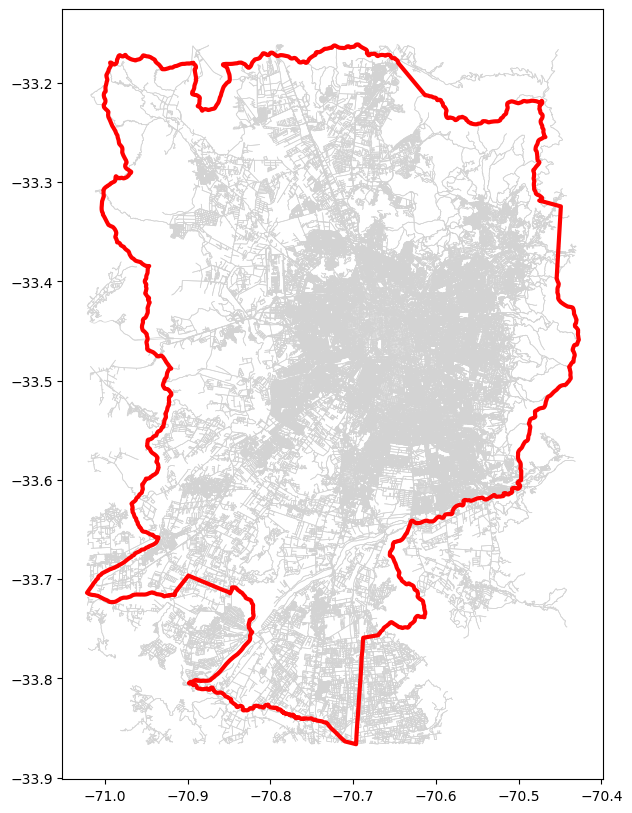

In [8]:
# Show
fig,ax = plt.subplots(figsize=(10,10))
edges.plot(ax=ax,zorder=1,linewidth=0.5,edgecolor='lightgray')
aoi.plot(ax=ax,facecolor='None',edgecolor='red',linewidth=3)

### Exploring length (No problem, average diff of 0.02 meters.)

In [9]:
edges_test = edges.to_crs("EPSG:32719").copy()
edges_test['longitud'] = edges_test.length
edges_test['diff'] = edges_test['longitud'] - edges_test['length']

# Show
print(f"Greater difference: {edges_test['diff'].max()} meters.")
print(f"Average difference: {edges_test['diff'].mean()} meters.")
edges_test.head(5)

Greater difference: 9.56896000811048 meters.
Average difference: -0.023614554122729177 meters.


,u,v,key,osmid,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,longitud,diff
0,14609420,448810971,0,279808979,False,2,Corregidor Zañartu,residential,<NA>,39.944,"LINESTRING (337026.591 6290130.743, 337026.422...",<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,39.839800,-0.104200
1,14609420,14609423,0,986531508,False,2,Cuatro Álamos,secondary,<NA>,187.178,"LINESTRING (337026.591 6290130.743, 337031.879...",<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,187.563803,0.385803
2,14609420,448811031,0,986531508,False,2,Cuatro Álamos,secondary,<NA>,26.317,"LINESTRING (337026.591 6290130.743, 337009.257...",<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,26.371396,0.054396
3,14609423,9192019941,0,986531508,False,2,Cuatro Álamos,secondary,<NA>,25.487,"LINESTRING (337214.139 6290128.268, 337239.676...",<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,25.540001,0.053001
4,14609423,448810953,0,8000600,False,2,Marco Polo,residential,<NA>,45.563,"LINESTRING (337214.139 6290128.268, 337214.207...",<NA>,<NA>,NaN,NaN,<NA>,<NA>,<NA>,45.444219,-0.118781
